In [1]:
from collections import namedtuple
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import sys


In [2]:
!pip install -U tensorflow-gpu
!pip install -U tensorflow_probability

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: tensorflow_probability in /usr/local/lib/python3.6/dist-packages (0.8.0)


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%load_ext autoreload
%load_ext tensorboard

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!nvidia-smi

Thu Oct 17 14:07:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:02:00.0  On |                  N/A |
|  0%   45C    P8    13W / 180W |   3470MiB /  8111MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   39C    P8    10W / 240W |    117MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
print(tf.__version__)

2.0.0


In [6]:
project_id = 'research-256112'
bucket_name = 'gs://jeromeku-seqvae-colab'
!gcloud config set project {project_id}

In [ ]:
def authenticate():
  from google.colab import auth
  auth.authenticate_user()

In [ ]:
authenticate()

In [7]:
def extract_array(npz):
  return np.stack([t for t in npz.values()], axis=0) 

!gsutil -m cp {bucket_name}/*.npz  .
train = extract_array(np.load('./train.npz'))
test = extract_array(np.load('./test.npz'))

train_ds, test_ds = map(tf.data.Dataset.from_tensor_slices, [train, test])

Copying gs://jeromeku-seqvae-colab/test.npz...
Copying gs://jeromeku-seqvae-colab/train.npz...
- [2/2 files][486.3 MiB/486.3 MiB] 100% Done   8.8 MiB/s ETA 00:00:00           
Operation completed over 2 objects/486.3 MiB.                                    


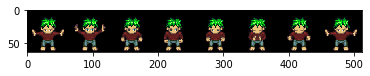

In [8]:
seq = np.concatenate([*train[0]], axis=1)
plt.imshow(seq)

#Alternatively
def plot_sprites(x):
  fig, axes = plt.subplots(1, len(x))

  for i, ax in enumerate(axes):
    _ = ax.imshow(x[i])
    ax.axis('off')
  
  return fig, axes
#fig, axes = plot_sprites(train[0])



In [9]:
Sprites = namedtuple('Sprites', ['length', 'frame_size', 'channels'])
sprites = Sprites(8, 64, 3)
sprites

Sprites(length=8, frame_size=64, channels=3)

In [14]:
!git clone https://github.com/jeromeku/seqvae.git

fatal: destination path 'seqvae' already exists and is not an empty directory.


In [ ]:
SOURCE_PATH = './seqvae'
if not SOURCE_PATH in sys.path:
    sys.path.append(SOURCE_PATH)

In [ ]:
#!cd seqvae/ && git pull

In [10]:
import disentangled.models as models

from disentangled.flags import FLAGS
FLAGS.mark_as_parsed()
from disentangled.summary import visualize_reconstruction, visualize_qualitative_analysis, image_summary, summarize_dist_params, summarize_mean_in_nats_and_bits

In [11]:
#Build model
model = models.DisentangledSequentialVAE(
      latent_size_static=FLAGS.latent_size_static,
      latent_size_dynamic=FLAGS.latent_size_dynamic,
      hidden_size=FLAGS.hidden_size, channels=sprites.channels,
      latent_posterior=FLAGS.latent_posterior)

In [12]:
#Optimizer and learning rate schedule
step = tf.Variable(0, dtype=tf.int64, trainable=False) 
schedule = tf.compat.v1.train.cosine_decay(FLAGS.learning_rate, step, FLAGS.max_steps)
optimizer = tf.keras.optimizers.Adam(schedule)

In [13]:
#GCS housekeeping
CLEAN = False

if CLEAN:
  !gsutil rm -r {bucket_name}/logs {bucket_name}/tf_ckpts


In [22]:
#Tensorboard  
timestamp = datetime.strftime(datetime.today(), "%y%m%d_%H%M%S")
logdir = os.path.join(bucket_name, 'logs',)
file_writer = tf.summary.create_file_writer(os.path.join(logdir, timestamp, 'train'))
file_writer.set_as_default()

PermissionDeniedError: Error executing an HTTP request: HTTP response code 401 with body '{
  "error": {
    "code": 401,
    "message": "Anonymous caller does not have storage.objects.list access to jeromeku-seqvae-colab.",
    "errors": [
      {
        "message": "Anonymous caller does not have storage.objects.list access to jeromeku-seqvae-colab.",
        "domain": "global",
        "reason": "required",
        "locationType": "header",
        "location": "Authorization"
      }
    ]
  }
}
'
	 when reading gs://jeromeku-seqvae-colab/logs/191017_135952/train/ [Op:CreateSummaryFileWriter]

In [16]:
#Checkpointing
checkpoint = tf.train.Checkpoint(step=step, optimizer=optimizer, net=model)
ckpt_manager = tf.train.CheckpointManager(checkpoint, os.path.join(bucket_name, 'tf_ckpts', timestamp), max_to_keep=3)

In [39]:
!gsutil ls {bucket_name}/*


gs://jeromeku-seqvae-colab/test.npz
gs://jeromeku-seqvae-colab/train.npz

gs://jeromeku-seqvae-colab/logs/:
gs://jeromeku-seqvae-colab/logs/191017_143935/
gs://jeromeku-seqvae-colab/logs/train_data/


In [ ]:
def train_step(*, model, optimizer, train_ds, test_ds, FLAGS, writer, checkpoint, checkpoint_manager):
    if checkpoint_manager.latest_checkpoint:
        checkpoint.restore(checkpoint_manager.latest_checkpoint)
        print(f"Restored from {checkpoint_manager.latest_checkpoint}")
    else:
        print("Initializing from scratch")
        
    step = checkpoint.step
    
    for inputs in train_ds.prefetch(buffer_size=None):
        with tf.compat.v2.summary.record_if(
            lambda: tf.math.equal(0, step % FLAGS.log_steps)
        ):
            tf.compat.v2.summary.histogram("image", data=inputs, step=step)

        with tf.GradientTape() as tape:
            features = model.compressor(inputs)  # (batch, timesteps, hidden)
            static_sample, static_posterior = model.sample_static_posterior(
                features, FLAGS.num_samples
            )  # (samples, batch, latent)
            dynamic_sample, dynamic_posterior = model.sample_dynamic_posterior(
                features, FLAGS.num_samples, static_sample
            )  # (sampl, N, T, latent)
            likelihood = model.decoder((dynamic_sample, static_sample))

            reconstruction = tf.reduce_mean(  # integrate samples
                input_tensor=likelihood.mean()[: FLAGS.num_reconstruction_samples],
                axis=0,
            )
            visualize_reconstruction(
                inputs, reconstruction, step, name="train_reconstruction"
            )

            static_prior = model.static_prior()
            _, dynamic_prior = model.sample_dynamic_prior(
                FLAGS.num_samples, FLAGS.batch_size, sprites.length
            )

            if FLAGS.enable_debug_logging:
                summarize_dist_params(static_prior, "static_prior", step)
                summarize_dist_params(static_posterior, "static_posterior", step)
                summarize_dist_params(dynamic_prior, "dynamic_prior", step)
                summarize_dist_params(dynamic_posterior, "dynamic_posterior", step)
                summarize_dist_params(likelihood, "likelihood", step)

            static_prior_log_prob = static_prior.log_prob(static_sample)
            static_posterior_log_prob = static_posterior.log_prob(static_sample)
            dynamic_prior_log_prob = tf.reduce_sum(
                input_tensor=dynamic_prior.log_prob(dynamic_sample), axis=-1
            )  # sum time
            dynamic_posterior_log_prob = tf.reduce_sum(
                input_tensor=dynamic_posterior.log_prob(dynamic_sample), axis=-1
            )  # sum time
            likelihood_log_prob = tf.reduce_sum(
                input_tensor=likelihood.log_prob(inputs), axis=-1
            )  # sum time

            if FLAGS.enable_debug_logging:
                with tf.compat.v1.name_scope("log_probs"):
                    summarize_mean_in_nats_and_bits(
                        static_prior_log_prob, FLAGS.latent_size_static, "static_prior", step
                    )
                    summarize_mean_in_nats_and_bits(
                        static_posterior_log_prob,
                        FLAGS.latent_size_static,
                        "static_posterior", step
                    )
                    summarize_mean_in_nats_and_bits(
                        dynamic_prior_log_prob,
                        FLAGS.latent_size_dynamic * sprites.length,
                        "dynamic_prior", step
                    )
                    summarize_mean_in_nats_and_bits(
                        dynamic_posterior_log_prob,
                        FLAGS.latent_size_dynamic * sprites.length,
                        "dynamic_posterior", step
                    )
                    summarize_mean_in_nats_and_bits(
                        likelihood_log_prob,
                        sprites.frame_size ** 2
                        * sprites.channels
                        * sprites.length,
                        "likelihood", step
                    )

            elbo = tf.reduce_mean(
                input_tensor=static_prior_log_prob
                - static_posterior_log_prob
                + dynamic_prior_log_prob
                - dynamic_posterior_log_prob
                + likelihood_log_prob
            )
            loss = -elbo
            tf.compat.v2.summary.scalar("elbo", elbo, step=step)

        grads = tape.gradient(loss, model.variables)
        grads, global_norm = tf.clip_by_global_norm(grads, FLAGS.clip_norm)
        grads_and_vars = list(zip(grads, model.variables))  # allow reuse in py3
        if FLAGS.enable_debug_logging:
            with tf.compat.v1.name_scope("grads"):
                tf.compat.v2.summary.scalar("global_norm_grads", global_norm, step=step)
                tf.compat.v2.summary.scalar(
                    "global_norm_grads_clipped", tf.linalg.global_norm(grads), step=step
                )
            for grad, var in grads_and_vars:
                with tf.compat.v1.name_scope("grads"):
                    tf.compat.v2.summary.histogram(
                        "{}/grad".format(var.name), data=grad, step=step
                    )
                with tf.compat.v1.name_scope("vars"):
                    tf.compat.v2.summary.histogram(var.name, data=var, step=step)
        optimizer.apply_gradients(grads_and_vars)

        is_log_step = step.numpy() % FLAGS.log_steps == 0
        is_final_step = step.numpy() == FLAGS.max_steps
        if is_log_step or is_final_step:
            checkpoint_manager.save()
            print("ELBO ({}/{}): {}".format(step.numpy(), FLAGS.max_steps, elbo.numpy()))
            with tf.compat.v2.summary.record_if(True):
                val_data = test_ds.take(20)
                inputs = next(iter(val_data.shuffle(20).batch(3)))
                visualize_qualitative_analysis(
                    inputs, model, step, FLAGS.num_reconstruction_samples
                )
        step.assign_add(1)
        writer.flush()


In [ ]:
FLAGS.enable_debug_logging = True
FLAGS.batch_size = 32 #default 32
FLAGS.max_steps = 1000 #default 10000
FLAGS.log_steps = 10
train_ds = train_ds.shuffle(1000).repeat()
train_set = train_ds.batch(FLAGS.batch_size).take(FLAGS.max_steps)
test_set = test_ds

In [ ]:
train_step(model=model, optimizer=optimizer, train_ds=train_set, test_ds=test_set, FLAGS=FLAGS, writer=file_writer, checkpoint_manager=ckpt_manager)

ELBO (0/1000): -93402.8984375
